In [1]:
from IPython.core.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from auxiliary import *
import warnings
import astropy

display(HTML("<style>.container { width:100% !important; }</style>"))
warnings.filterwarnings("ignore", module='astropy.io.votable.tree')
%matplotlib inline

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


# Notebook structure

The notebook consists of four classes:

- catalogueProcessing
    - Used to perform queries and crossmatches
- Astrometry
    - Currently hosts functions for 
        - generating histograms
        - fitting gaussians
    - If HDbscan is implemented, it would go here.
- Photometry
    - Will have methods for making photometric cuts
- Visualization
    - Has methods for plotting, including
        - Plotting single columns
        - Plotting sources overlayed on an image
        - Plotting a gaussian fitted to a histogram generated from
          an arbitrary axis.
    - Will have method for plotting photometric cuts over the appropriate diagram






When catalogProcessing is instantiated, it queries gaia, 2mass, and allwise. This class also provides the ability to query any catalog availible from IRSA. __[More info here.](https://irsa.ipac.caltech.edu/docs/program_interface/TAP.html)__

Parallax for the cluster is optional and has units of milliarcseconds. If given, the radius is assumed to be physical (in pc), otherwise the radius is assumed to be angular (in degrees).

Querying Gaia...
Creating query...
INFO: Query finished. [astroquery.utils.tap.core]
Retrieving results...
Done querying Gaia!
Querying TMASS...
Created TAP+ (v1.2.1) - Connection:
	Host: irsa.ipac.caltech.edu
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Creating query...
INFO: Query finished. [astroquery.utils.tap.core]
Retrieving results...
Done querying TMASS!
Querying Allwise...
Created TAP+ (v1.2.1) - Connection:
	Host: irsa.ipac.caltech.edu
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Creating query...
INFO: Query finished. [astroquery.utils.tap.core]
Retrieving results...
Done querying Allwise!


auxiliary.py:929: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt(full_table['phot_g_n_obs']/full_table['phot_g_mean_flux_over_error'])


Full table generated.

Gaia:
Total rows: 798
G: 389
BP: 389
RP: 389
PLX: 389
PMRA: 389
PMDEC: 389

2MASS:
Total rows: 798
J: 491
H: 491
K: 491

allwise:
Total rows: 798
W1: 440
W2: 440
W3: 440
W4: 440


auxiliary.py:2205: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(fractional[good_data]),param_data[good_data])


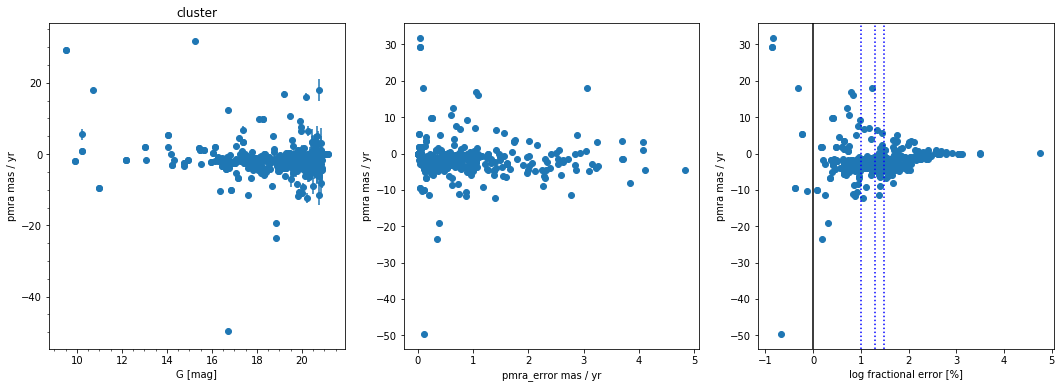

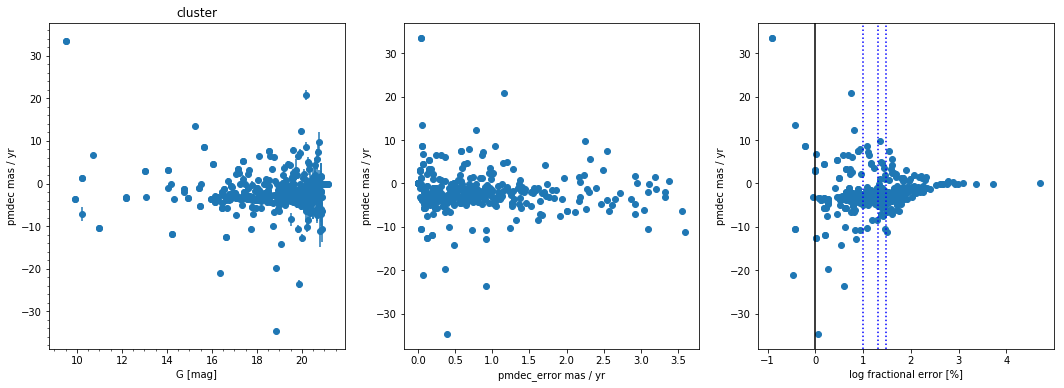

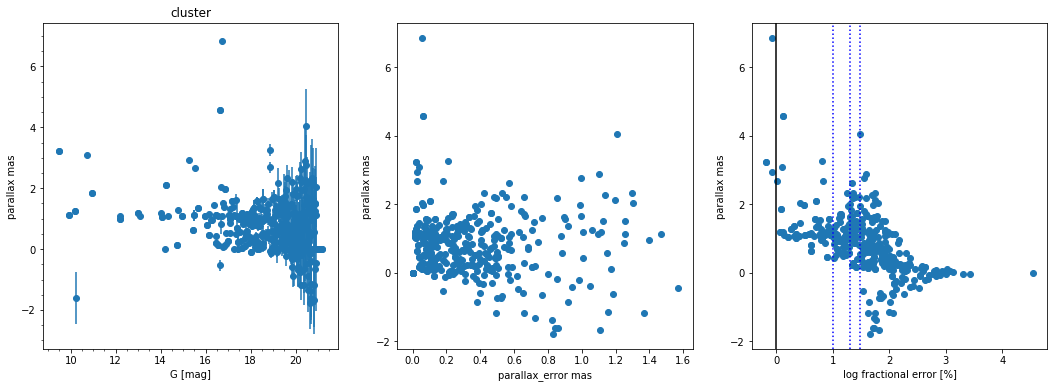

In [2]:
# Define region of interest parameters
ra_cen = 325.73829672260 # degrees
dec_cen = 66.10962867115 # degrees
plx = 1.8481 # milliarcseconds, optional
rad = 0.75 # pc if plx is given, degrees if it is not

coords = str(ra_cen) + "+" + str(dec_cen)

# Instantiates catalogProcessing:
cat_pr = catalogProcessing(coords,radius=rad, parallax=plx)

# Builds the full data table:
full_table = cat_pr.generate_full_table(gen_small_table=True)

# Instantiates the Visualization and Photometry classes
vis = Visualization(full_table, coords)
phot = Photometry(full_table)

# Generates diagnostic error plots:
#  proper motion, right ascension
vis.plot_error('pmra')
#  proper motion, declination
vis.plot_error('pmdec')
#  parallax
vis.plot_error('parallax')

Below cell generates a full table consisting of all sources in gaia, 2mass, and allwise at 1pc around the search coordinates (as specified upon instantiation of catalogueProcessing). If a source wasn't crossmatched with a particular catalogue, the column values of this catalogue will be masked.

set gen_small_table to False to return a table with all columns from all three surveys

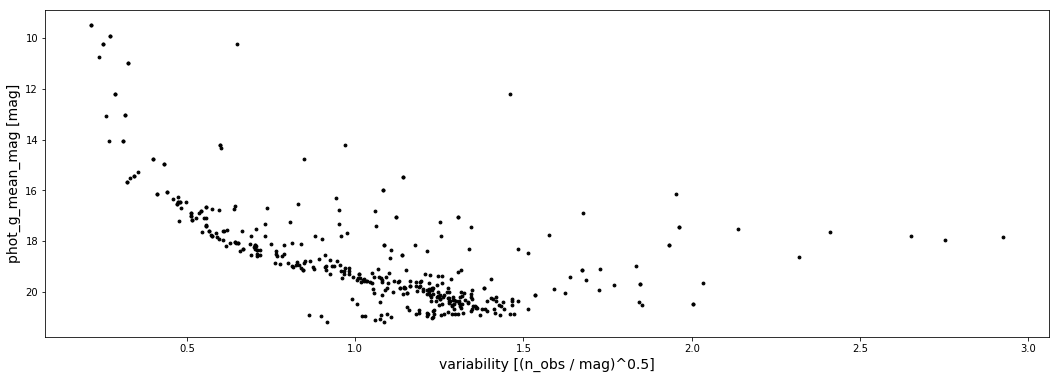

In [3]:
# Generates diagnostic plots of ra, dec, parallax, proper motion, and others.
#vis.plot_diagnostics()
vis.plot("variability","phot_g_mean_mag",invert_y=True)

Below cell crossmatches the gaia table with the 2mass table. The xmatch radius is determined by looking at the errors of respective match (nearest neighbour) and selecting only objects that are closer than the combined error radii.

The method returns a list of indicies and distances that associates objects in catalogue1 with those in catalogue2.

In [4]:
#xmatch_res = cat_pr.xmatch(cat_pr.gaia, cat_pr.tmass, ["ra", "dec", "ra_error", "dec_error"], ["ra", "dec", "err_maj", "err_min"])
#print(xmatch_res)

plot_image_overlay gets images from the list of surveys passed to it and plots the sources from the list aux.Visualization was instantiated with, in this case gaia, superimposed on them.

I'll have to do something about overcrowding when there are many sources.

In [5]:
#vis.plot_images(['DSS2 Red', '2MASS-J', 'WISE 4.6', 'WISE 22'], cats_to_plot=["gaia", "allwise"])
#https://astroquery.readthedocs.io/en/latest/skyview/skyview.html

In [6]:
#vis.plot_hist("parallax", "Parallax")
#vis.plot_hist("pmra", "pm RA [mas/yr]")
#vis.plot_hist("pmdec", "pm Dec [mas/yr]")

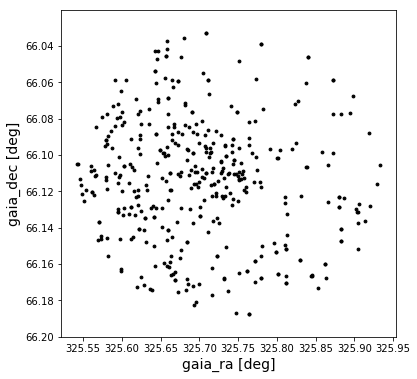

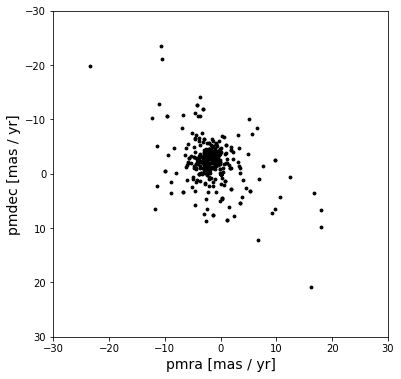

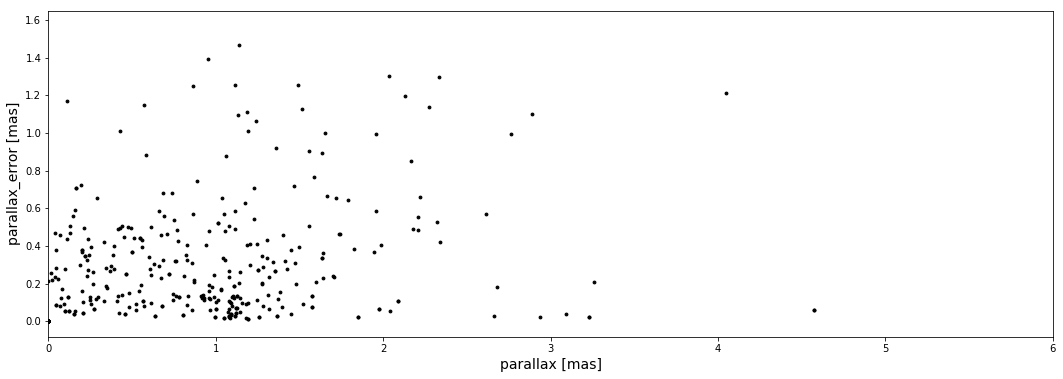

In [7]:
vis.plot("gaia_ra", "gaia_dec", squared=True, invert_y=True)
vis.plot("pmra", "pmdec",xlim=(-30,30),ylim=(-30,30), squared=True, invert_y=True)
vis.plot("parallax", "parallax_error", xlim=(0,6))
# full_table doesn't currently have a parallax_error column. This may be an oversight in the generate_full_table function?

In [8]:
#redder, not_redder = phot.keep_reddest()
#vis_redder = Visualization(redder, coords)
#vis_redder.plot_diagnostics()

In [9]:
#likely_disks, not_likely_disks = phot.keep_likely_disks()
#vis_likely_disks = Visualization(likely_disks, coords)
#vis_likely_disks.plot_diagnostics()

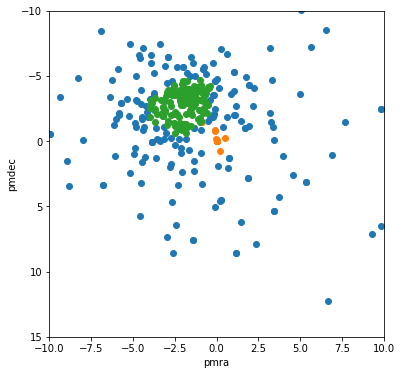

In [10]:
candidates_table, cluster_membership = cat_pr.identify_clusters(full_table, column_A="pmra", column_B="pmdec")
vis.plot_clusters(candidates_table, cluster_membership, column_A="pmra", column_B="pmdec", xlim=(-10,10), ylim=(-10,15))

In [11]:
print(cluster_membership)

[-1 -1  1  1  1  1 -1  1 -1  1 -1 -1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1
 -1 -1  1  1  1 -1 -1 -1  1 -1  1 -1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1
 -1  1  1  1  1 -1  0  1  1  1 -1 -1 -1 -1  1  1 -1 -1  0 -1  1  1  1  1
  0  1  1  0  1  1  1  1 -1 -1  1  1  1 -1  0 -1  1  0  1  1  0  1  1  1
  1  0  1 -1 -1  1 -1 -1 -1  1  1  1 -1 -1  1  1  0  1 -1  1 -1  1  1 -1
 -1 -1  1  1 -1  1 -1  1  1  1  1  1 -1  1  1 -1  1  1 -1  1 -1  1  0  1
  1  1 -1  1  1 -1 -1 -1 -1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1
 -1 -1  1 -1  1 -1 -1  1  1 -1  1  1 -1  1  1 -1 -1 -1  1 -1  1 -1 -1  1
  1  1  1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1  1 -1  1 -1 -1  1  1 -1 -1 -1
 -1 -1 -1 -1  1 -1  1  1 -1  1  0 -1 -1 -1  1 -1 -1 -1  1 -1  0 -1  0 -1
  1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1  0  1 -1  0 -1 -1  0  0  0 -1 -1 -1
 -1 -1  1  0  0  1 -1  0  1 -1  1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1  1 -1  1 -1 -1 -1  0 -1  1 -1 -1 -1
  1 -1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1